Задание: на сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [241]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
warnings.filterwarnings("ignore", category=UserWarning) 


In [242]:
df = pd.read_excel('AB_Test_Results.xlsx', sheet_name=0)
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [243]:
# Переименуем столбцы для удобства работы
df = df.rename(columns={'USER_ID': 'id',
                   'VARIANT_NAME': 'variant',
                   'REVENUE': 'revenue'})

Проведем EDA

In [244]:
# Оценим данные в сериях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   variant  10000 non-null  object 
 2   revenue  10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [245]:
# Оценим наличие NA
df.isna().sum()

id         0
variant    0
revenue    0
dtype: int64

In [246]:
# Проверка наличия дубликатов
duplication= df[df.duplicated]
duplication.index



Index([ 106,  195,  224,  302,  422,  494,  545,  578,  587,  609,
       ...
       9976, 9980, 9984, 9985, 9987, 9989, 9993, 9994, 9995, 9997],
      dtype='int64', length=2067)

In [247]:
# Уберем дубликаты из датафрейма
df = df.drop_duplicates(keep='first')
df

,id,variant,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9991,8864,variant,0.0
9992,9303,variant,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [248]:
# Рассмотрим пользователей, попавших в оба варианта
two_variant_users = df.groupby('id', as_index =False).agg({'variant': 'count'})
two_variant_users.head()



,id,variant
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1


In [249]:
# Выберем всех пользовтелй, которые попали более чем в одну группу и получим их id
some_variants_users = two_variant_users[two_variant_users['variant'] > 1]['id']


In [250]:
# Получим только тех пользователей, которые попали в одну группу
df = df[df['id'].isin(some_variants_users) == False]
df.head()

,id,variant,revenue
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


In [251]:
# Разделим оставшихся пользователей по вариантам
test = df.groupby('variant', as_index =False).agg({'revenue': 'sum',
                                            'id': 'count'})

In [252]:
# Оценим количество не нулевых значений выручки
df[df['revenue'] > 0].agg({'revenue': 'count'})

revenue    58
dtype: int64

In [253]:
# Создадим переменную с положительнй выручкой
positive_revenue = df[df['revenue']>0]
positive_revenue.head()


,id,variant,revenue
149,8110,variant,1.75
152,8607,control,2.99
628,6365,control,10.63
758,4445,control,17.05
853,8089,control,2.17


In [254]:
# Расчетаем перцентиль положительной выручки
percentil = np.percentile(positive_revenue['revenue'], [25, 50, 75])


In [255]:
# Расчитаем IOR и получим границы усов boxplot
IQR = percentil[2] - percentil[0]

In [256]:
# Получим верхнюю и нижнюю границы боксплота (1,5IQR)
up_border = percentil[2] + 1.5*IQR
low_border = percentil[0] - 1.5*IQR
print('Верхняя: {borders[0]} и нижняя {borders[1]} граница боксплота'.format(borders = [up_border, low_border]))

Верхняя: 10.743750000000002 и нижняя -4.446250000000001 граница боксплота


<Axes: ylabel='revenue'>

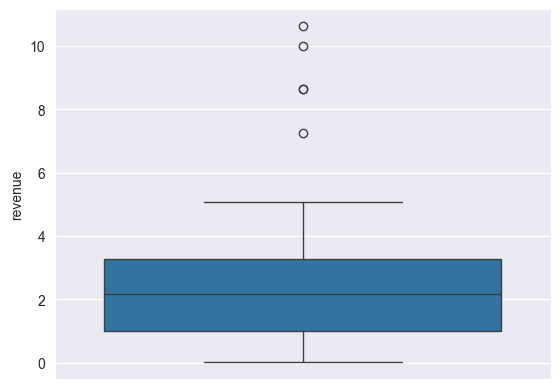

In [257]:
# Построим боксплот, учитывая рассчитанные границы (верхнюю)
sns.boxplot(positive_revenue[positive_revenue['revenue'] < up_border]['revenue'])

In [258]:
df_revenue = df.groupby('revenue').agg({'revenue': 'count'})
df_revenue = df_revenue.rename(columns={'revenue': 'count'})
df_revenue.describe()

,count
count,48.000000
mean,98.854167
std,676.332286
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4687.000000


C:\Users\evgen\AppData\Local\Temp\ipykernel_2288\2997954619.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  sns.scatterplot(df_revenue[0:45], x='revenue', y='count')


<Axes: xlabel='revenue', ylabel='count'>

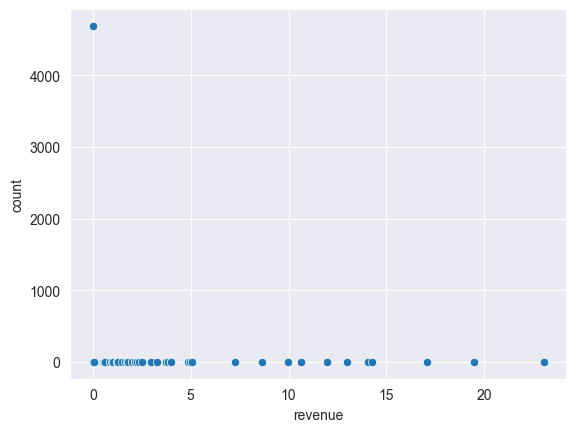

In [259]:
sns.scatterplot(df_revenue[0:45], x='revenue', y='count')

In [260]:
# Оценим выручку по группам
control_revenue = df[df['variant'] == 'control']['revenue']

In [261]:
variant_revenue = df[df['variant'] == 'variant']['revenue']

In [262]:
# Сгруппируем данные по вариантам
df.groupby('variant', as_index=False).agg({'revenue': 'sum',
                                           'variant': 'count'})

,revenue,variant
0,335.06,2366
1,121.81,2379


In [263]:
# Ввиду ненормальности распределения при графической оценке двух выборок, проводим непараметрический U-тест для двух независимых выборок
U, p = st.mannwhitneyu(control_revenue, variant_revenue)
'Нулевая гипотеза {} отклоняется, т.к. {} {} 0.05'.format('не', p, '>' if p > 0.05 else '<')

'Нулевая гипотеза не отклоняется, т.к. 0.7709806275559624 > 0.05'

In [264]:
# Оценим статистическую мощность теста. Рассчитаем стандартное отклонение
С_std = control_revenue.std()
V_std = variant_revenue.std()
print(С_std, V_std)


4.097082540225501 0.7746616401686576


In [265]:
# Рассчитаем длину серий
C_n = len(control_revenue)
V_n = len(variant_revenue)
print(C_n, V_n)

2366 2379


In [266]:
# Рассчитаем S (standard deviation pull)
S = np.sqrt((V_std**2 + С_std**2)/2)
S

2.9484051619620937

In [267]:
ef_size = float((control_revenue.mean() - variant_revenue.mean())/2)
ef_size

0.04520617675724864

In [272]:
# Парметы для power анализа
alpha = 0.05

analysis =  TTestIndPower()
result = analysis.solve_power(effect_size=ef_size, power=None,
nobs1=C_n, ratio=1.0, alpha=alpha)
result # Низкая статистическая мощность


0.3428033131382452

Исходя из полученных результатов можно дать следующий совет менеджеру: оставляем котнрольную версию продукта ввиду, однако не исключена ошибка второго рода ввиду малой мощности теста